In [2]:
import numpy as np
import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube
import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d

import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [3]:
scale = 64
border = 10
radius = 10

sigma_low = 3.0
sigma_high = 1.0

In [6]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=1.0)
_, instance_map_0, class_map_0 = obj.fill()

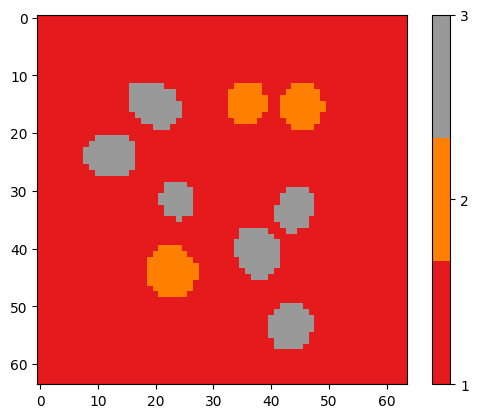

In [7]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[32,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [9]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

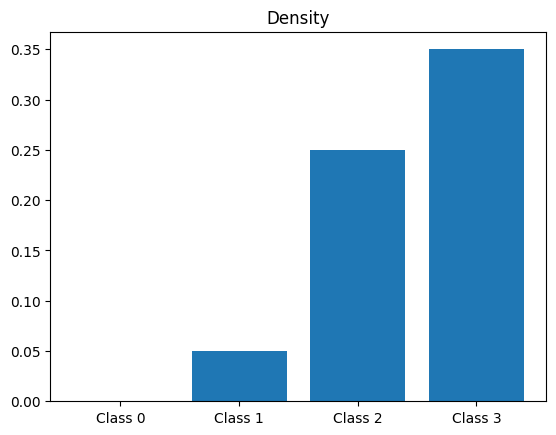

In [10]:
tomo_class_0 = np.array([0])
tomo_class_1 = np.array([0.05])
tomo_class_2 = np.array([0.25])
tomo_class_3 = np.array([0.35])
class_actions_tomo = np.column_stack([tomo_class_0,
                                      tomo_class_1,
                                      tomo_class_2,
                                      tomo_class_3]).T

plt.bar( ["Class 0", "Class 1", "Class 2", "Class 3"],class_actions_tomo.ravel() )
plt.title("Density")
plt.show()

In [11]:
low_map = mm3d.compute_weighted_map(class_map_low, class_actions_tomo)
high_map = mm3d.compute_weighted_map(class_map_high, class_actions_tomo)

low_map = low_map + mm3d.noise(low_map, 0.01, 0.0)
high_map = high_map + mm3d.noise(high_map, 0.01, 0.0)

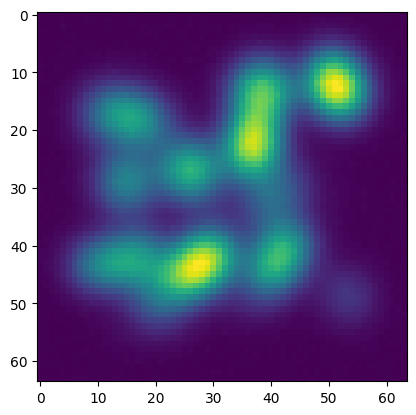

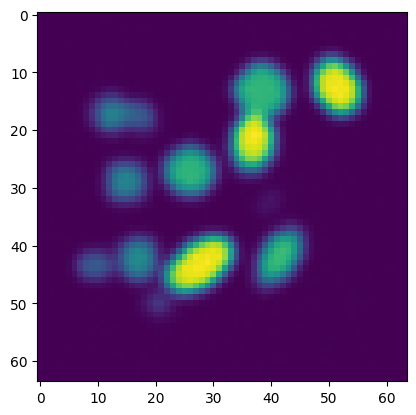

In [12]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

Now that we have data, I will use have to make the geometric objects

In [13]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [14]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T 
print(UV.shape, XYZ.shape)

torch.Size([4096, 2]) torch.Size([262144, 3])


In [17]:
aligner_1 = embedplane.Plane3DAligner(
    normal=[0.0, 0.00, 1.0], 
    point_on_plane=[scale//2, scale//2, scale//2]
)
point_on_plane_2D_1 = (scale//2,scale//2)
aligned_points_1 = aligner_1.align_points_to_3d(UV, point_on_plane_2D_1, rotation_angle=0)

aligner_2 = embedplane.Plane3DAligner(
    normal=[0.0, -1.0, 0.0], 
    point_on_plane=[scale//2, scale//2, scale//2]
)
point_on_plane_2D_2 = (scale//2,scale//2)
aligned_points_2 = aligner_2.align_points_to_3d(UV, point_on_plane_2D_2, rotation_angle=0)




In [18]:
indices_1, near_dist_1 = interpolate.find_nearest(XYZ, aligned_points_1, 5)
weights_1 = interpolate.compute_weights(near_dist_1, power=3.0, cutoff=2.0)

indices_2, near_dist_2 = interpolate.find_nearest(XYZ, aligned_points_2, 5)
weights_2 = interpolate.compute_weights(near_dist_2, power=3.0, cutoff=2.0)



In [19]:
funct_1 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_1, 
                                                                         weights_1)
funct_2 = interpolate.inverse_distance_weighting_with_weights(torch.Tensor(high_map.flatten()), 
                                                                         indices_2, 
                                                                         weights_2)



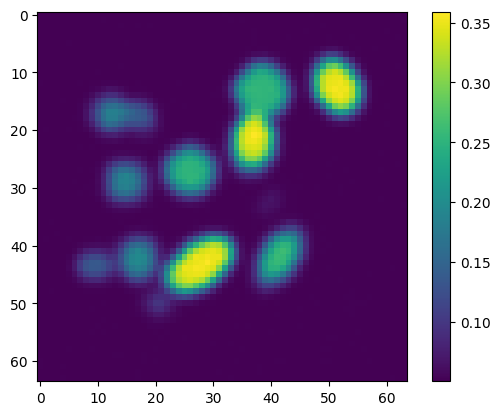

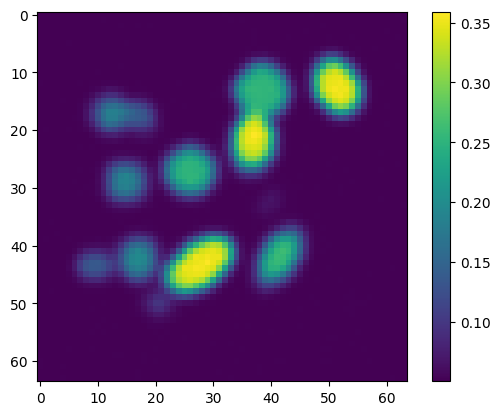

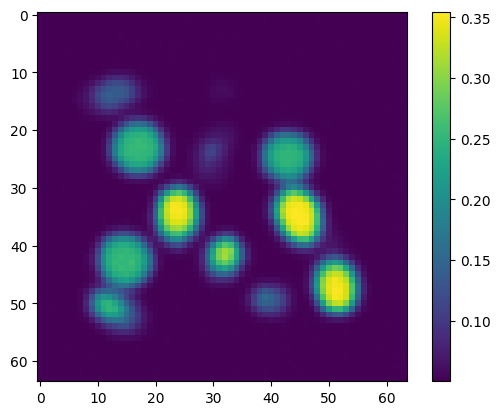

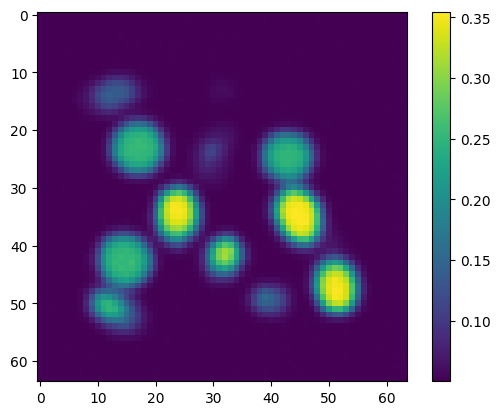

In [20]:
funct_1= einops.rearrange(funct_1, "(X Y) -> X Y ",X=scale, Y=scale)
plt.imshow(funct_1.numpy() )
plt.colorbar()
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

funct_2 = einops.rearrange(funct_2, "(X Y) -> X Y",X=scale, Y=scale)
plt.imshow(funct_2.numpy() )
plt.colorbar()
plt.show()


plt.imshow( high_map[0, :,scale//2,:]) 
plt.colorbar()
plt.show()




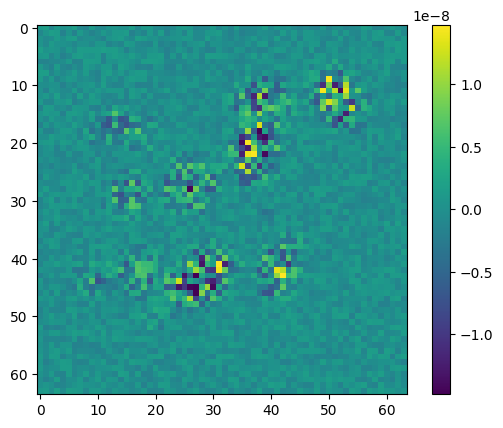

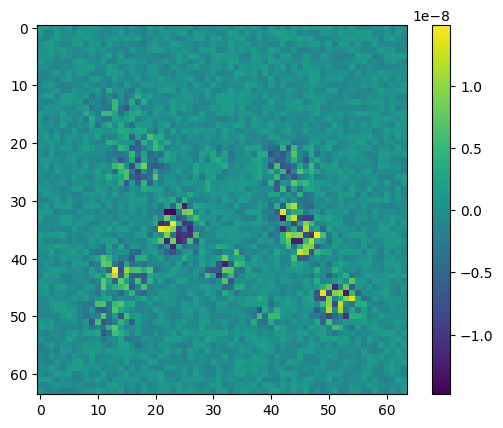

In [21]:
plt.imshow(funct_1.numpy() - high_map[0, :,:,scale//2])
plt.colorbar()
plt.show()

plt.imshow(funct_2.numpy() - high_map[0, :,scale//2,:])
plt.colorbar()
plt.show()


Build Data Loader

In [22]:
my_3d_maps = torch.concat([torch.Tensor(low_map).unsqueeze(0),
                           torch.Tensor(low_map).unsqueeze(0)])
my_2d_maps = torch.concat([torch.Tensor(high_map[0, :,:,32]).flatten().unsqueeze(0),
                           torch.Tensor(high_map[0, :,32,:]).flatten().unsqueeze(0)])
my_weights = torch.concat([weights_1.unsqueeze(0), weights_2.unsqueeze(0) ])
my_indices = torch.concat([indices_1.unsqueeze(0), indices_2.unsqueeze(0)])
                           

In [23]:
my_data = TensorDataset(my_3d_maps, my_2d_maps, my_weights, my_indices)                          
data_loader = DataLoader(my_data, batch_size=1) 

In [53]:
layers = 20
hidden_out_channels = [3]
dilation_choices = [1,2,3,]
sizing_settings = None
layer_probabilities = {'LL_alpha': 0.750,
                               'LL_gamma': 0.0,
                               'LL_max_degree': None,
                               'LL_min_degree': 1,
                               'IL': 0.995,
                               'LO': 0.995,
                               'IO': True}

net = sms3d.random_3DSMS_network(in_channels=1,
                         out_channels=1,
                         layers=layers,
                         dilation_choices=dilation_choices,
                         in_shape=(64, 64, 64),
                         out_shape=(64, 64, 64),
                         hidden_out_channels=None,
                         layer_probabilities=layer_probabilities,
                         sizing_settings=None,
                         dilation_mode="Edges",
                         network_type="Regression",
                         )

In [54]:
def train_model(net, loss_function, optimizer, dataloader, num_epochs, interpolate_function, device='cuda:0'):
    net.to(device)  # Move the network to the specified device
    net.train()  # Set the network to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0

        for batch in dataloader:
            img_tensor_3d, flat_2d_tensor, weights, indices = [item.to(device) for item in batch]

            # Forward pass
            outputs = net(img_tensor_3d)
            loss = 0.0
            for img3d, img2d, ws, idx in zip(outputs, flat_2d_tensor, weights, indices):
                img_flat = img3d.flatten()
                interp = interpolate_function(img_flat, idx, ws)
                not_nan_sel = ~torch.isnan(interp)

                # Compute loss
                loss += loss_function(interp[not_nan_sel], img2d[not_nan_sel])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

In [55]:
# Create an L1 loss function
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0051)  # You can adjust the learning rate as needed
train_model(net, 
            loss_function, 
            optimizer, 
            data_loader, 
            500, 
            interpolate.inverse_distance_weighting_with_weights, device='cpu')


Epoch [1/500], Loss: 0.008027423173189163
Epoch [2/500], Loss: 0.002765519078820944
Epoch [3/500], Loss: 0.0018539612647145987
Epoch [4/500], Loss: 0.001310521096456796
Epoch [5/500], Loss: 0.001436015299987048
Epoch [6/500], Loss: 0.0012240185751579702
Epoch [7/500], Loss: 0.0009415785316377878
Epoch [8/500], Loss: 0.001013567001791671
Epoch [9/500], Loss: 0.0009270253649447113
Epoch [10/500], Loss: 0.000766808312619105
Epoch [11/500], Loss: 0.0008117126417346299
Epoch [12/500], Loss: 0.0007519756618421525
Epoch [13/500], Loss: 0.0006827781617175788
Epoch [14/500], Loss: 0.0006831652135588229
Epoch [15/500], Loss: 0.0006332922785077244
Epoch [16/500], Loss: 0.0006060099112801254
Epoch [17/500], Loss: 0.0006001286092214286
Epoch [18/500], Loss: 0.0005636869755107909
Epoch [19/500], Loss: 0.0005514671065611765
Epoch [20/500], Loss: 0.0005434083577711135
Epoch [21/500], Loss: 0.0005172334931557998
Epoch [22/500], Loss: 0.0005125032039359212
Epoch [23/500], Loss: 0.0005016432551201433
Epo

KeyboardInterrupt: 

In [56]:
with torch.no_grad():
    tmp3 = net.cpu()(torch.Tensor(low_map).unsqueeze(0))

In [57]:
m = (tmp1+tmp2+tmp3)/3.0
s = torch.sqrt((tmp1**2+tmp2**2+tmp3**2)/3.0 - m*m)

In [58]:
import napari

v = napari.view_image(low_map)
v.add_image(m.numpy()[0])
v.add_image(s.numpy()[0])
v.add_image(high_map)

<Image layer 'high_map' at 0x2d20eba00>

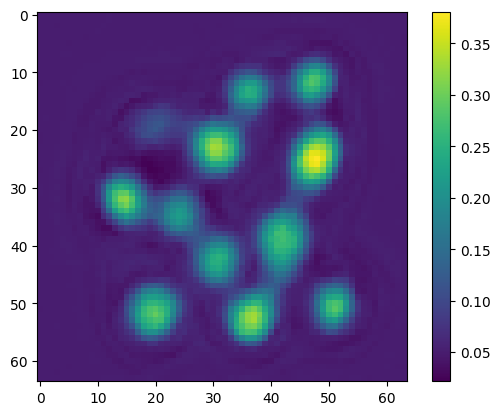

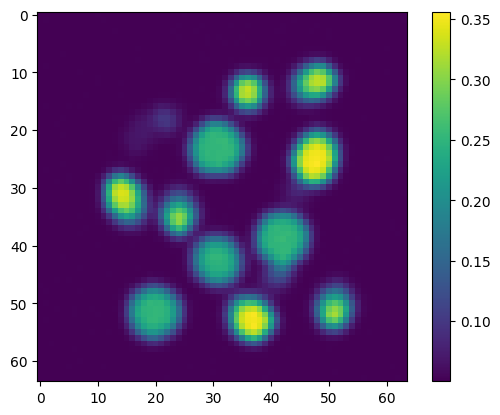

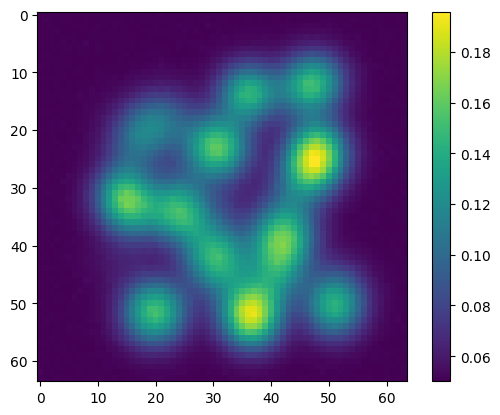

In [59]:
plt.imshow(m.numpy()[0, 0,:,:,scale//2-15])
plt.colorbar()
plt.show()

plt.imshow(high_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()


plt.imshow(low_map[0,:,:,scale//2-15])
plt.colorbar()
plt.show()